# Analysis of "Welfare"


Completion rate: 0.9
Participants who confirmed their answers the first time: 0.8888888888888888


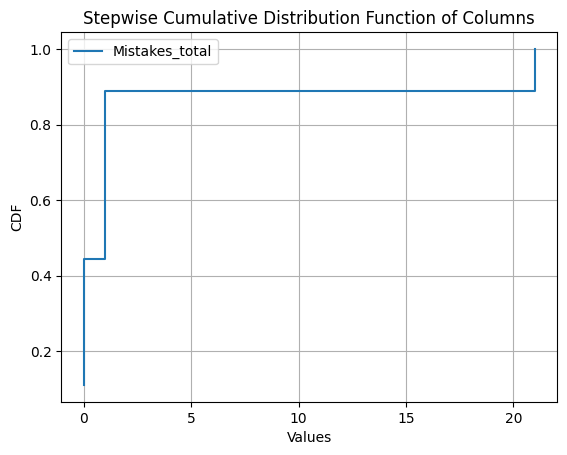

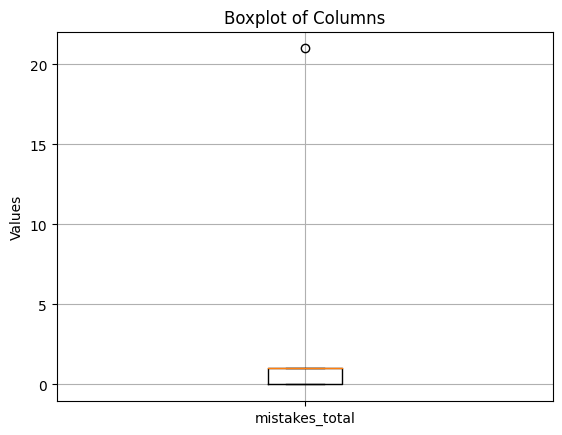

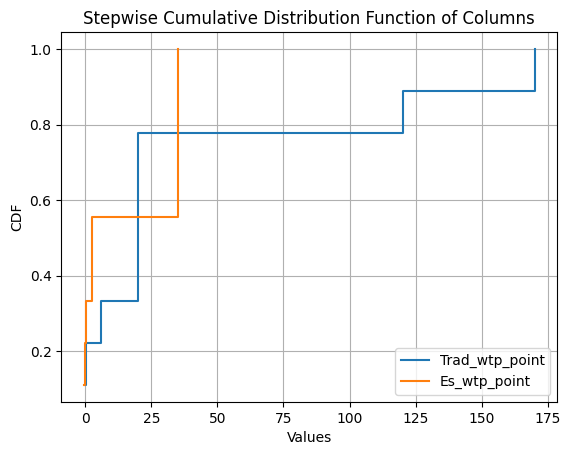

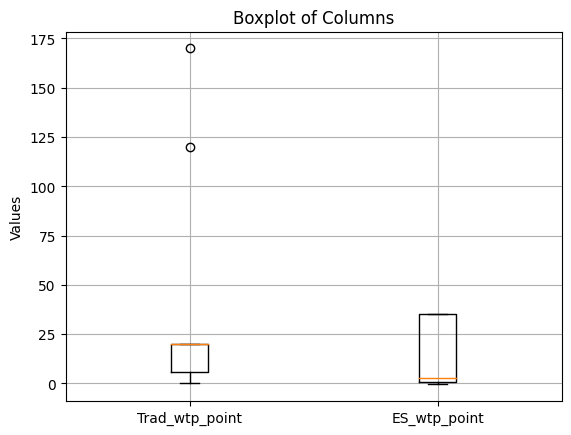

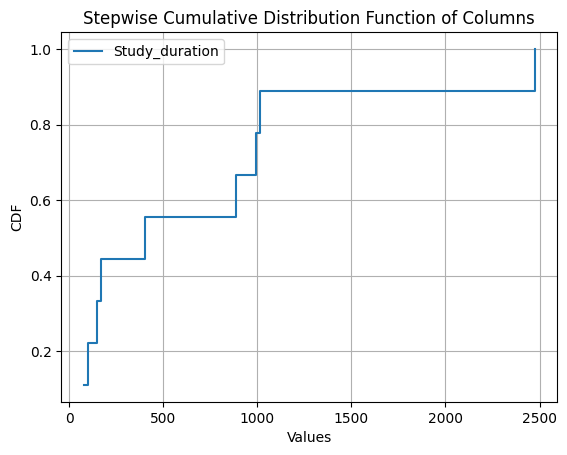

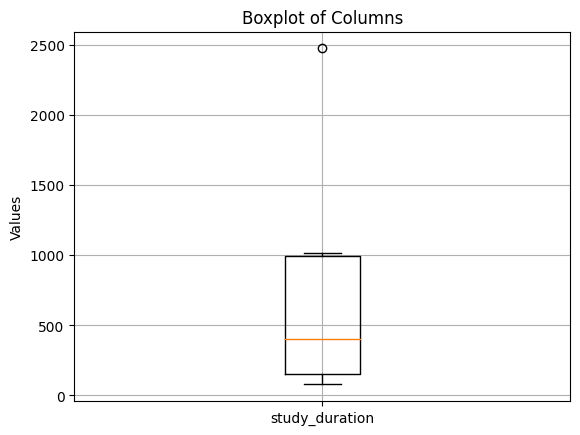

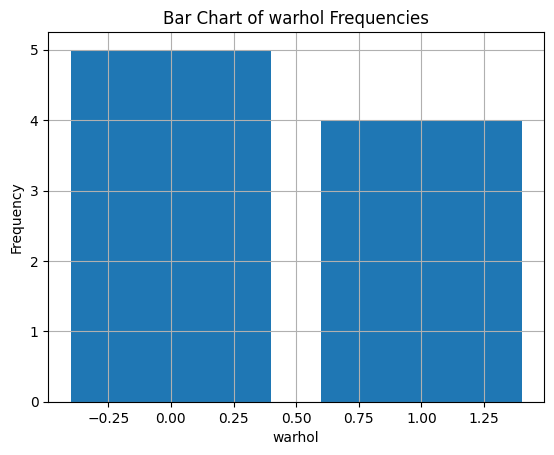

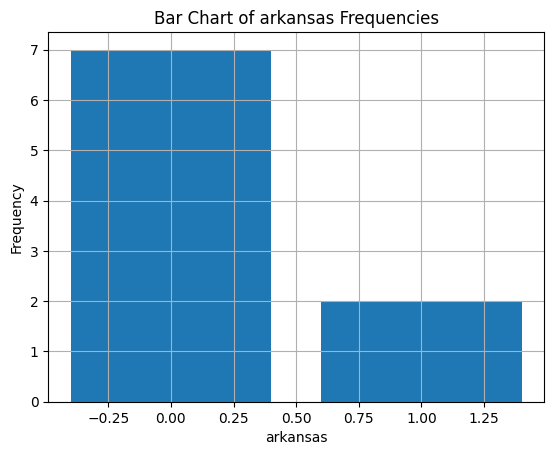

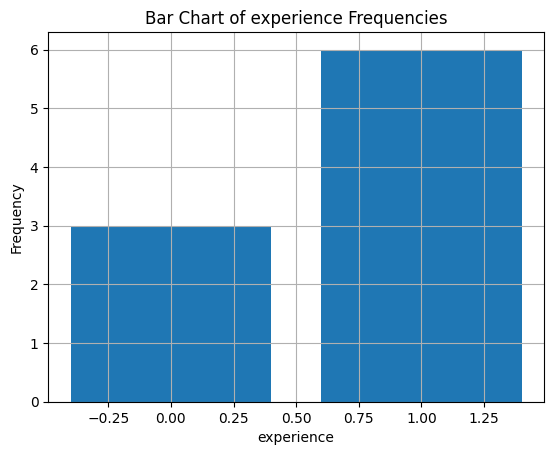

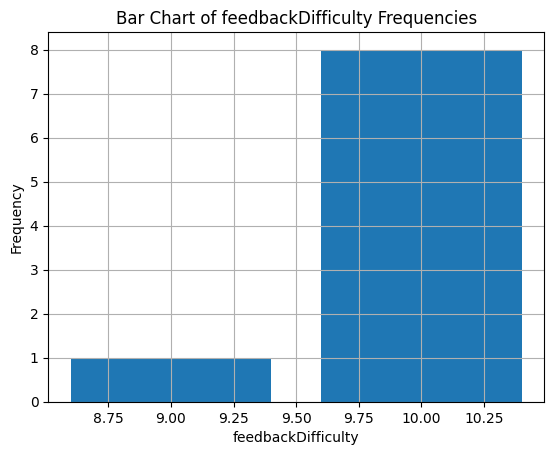

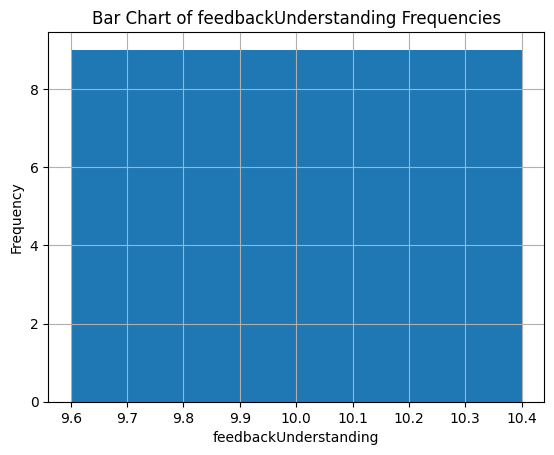

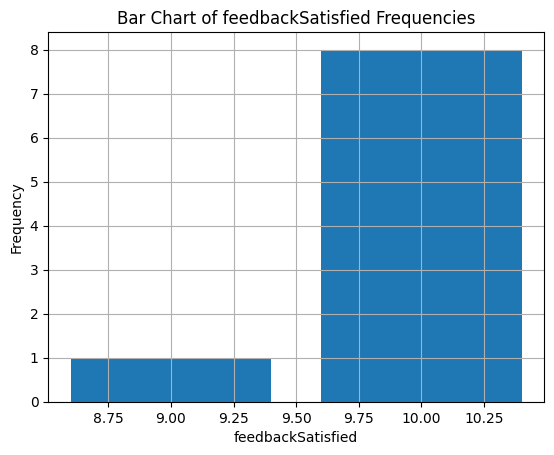

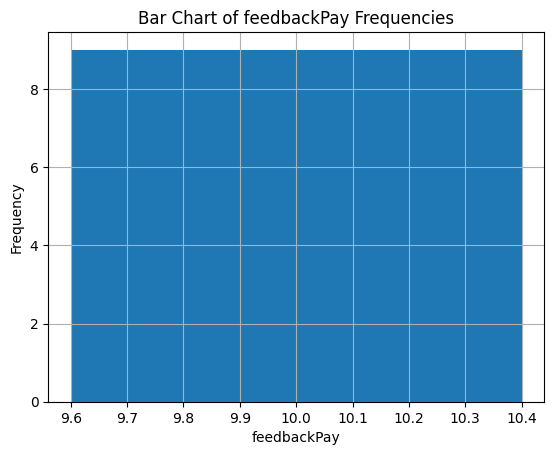

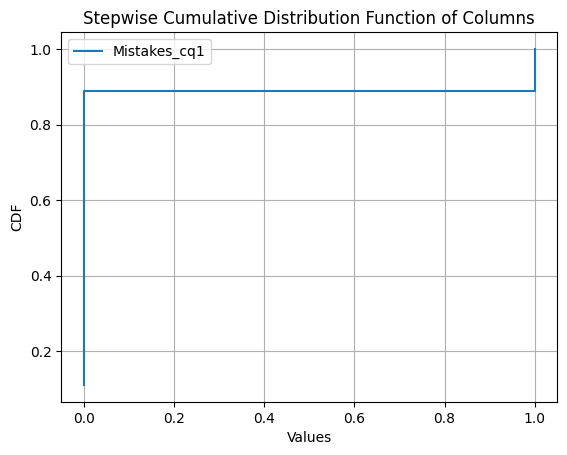

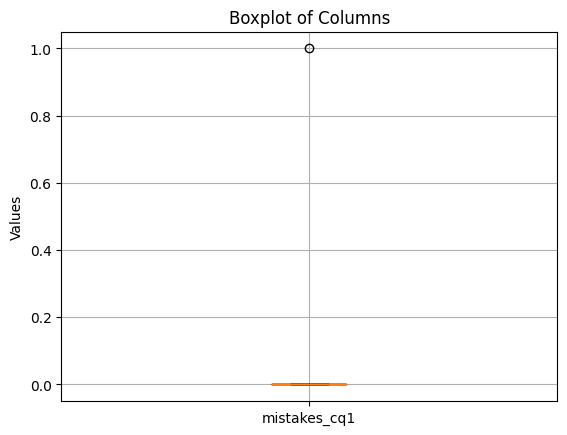

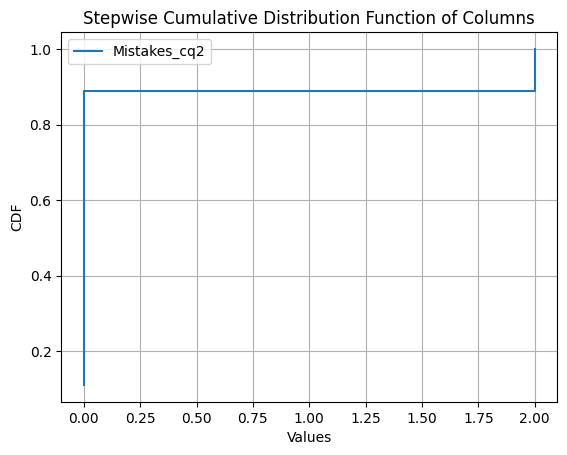

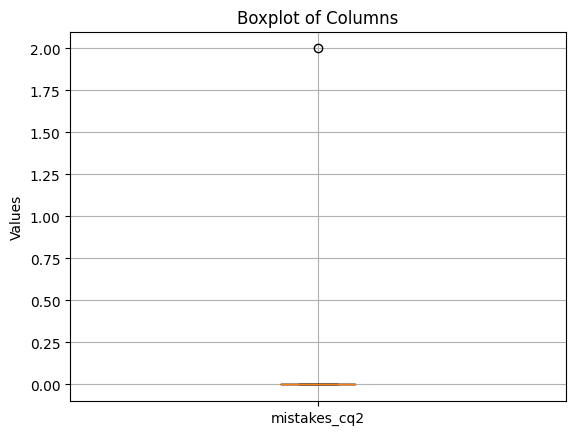

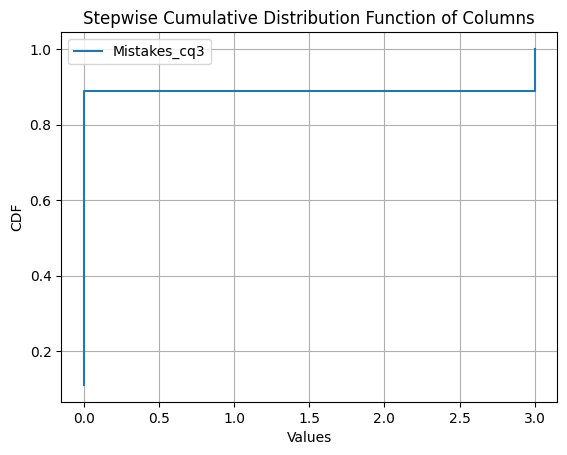

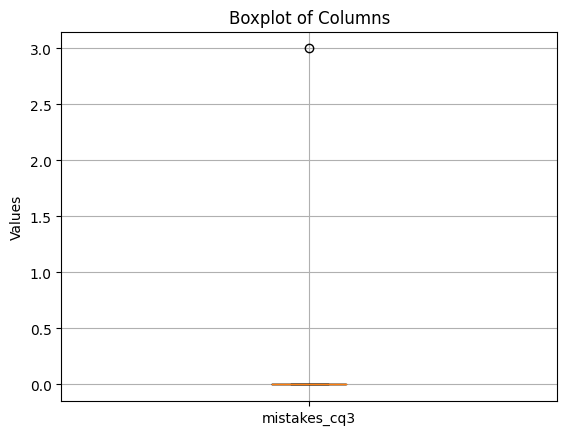

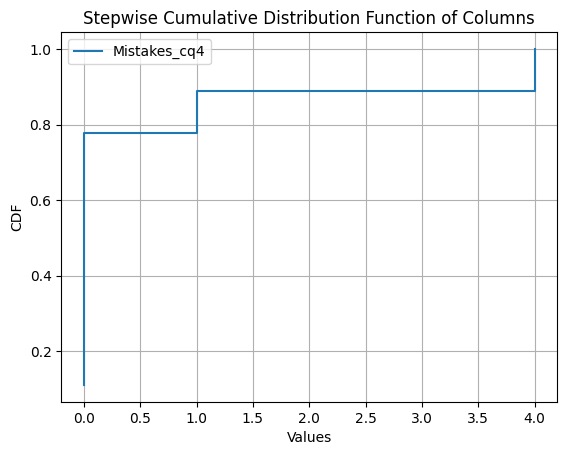

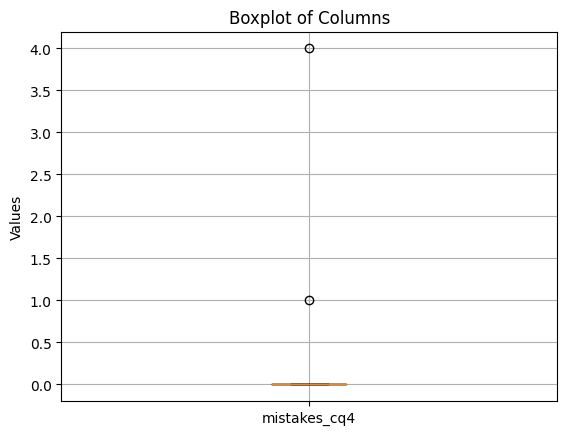

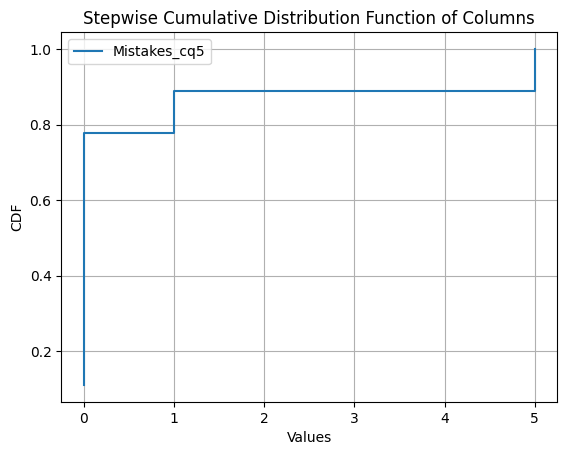

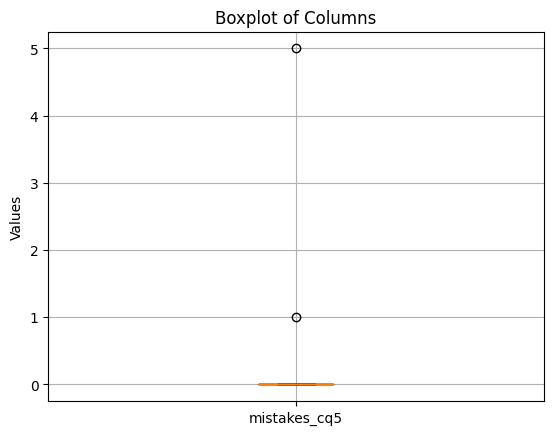

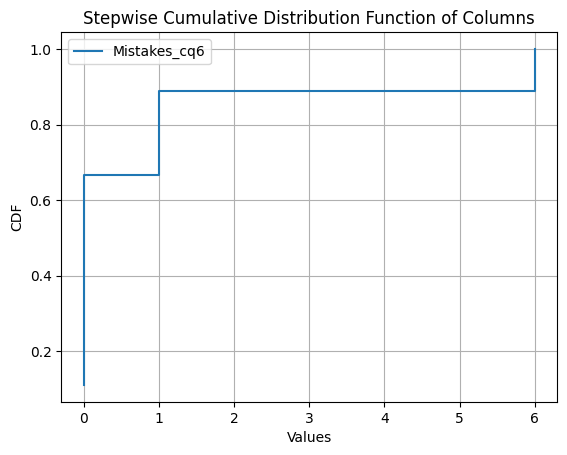

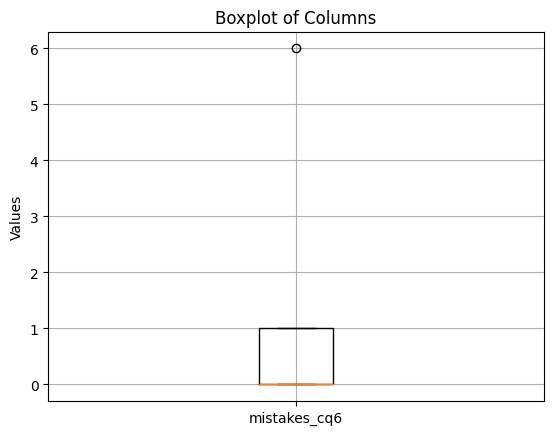

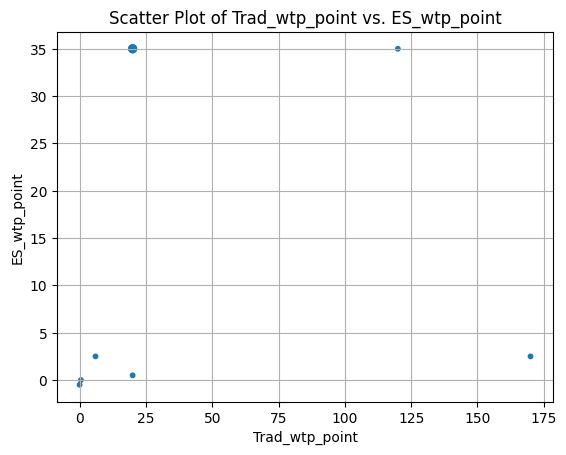

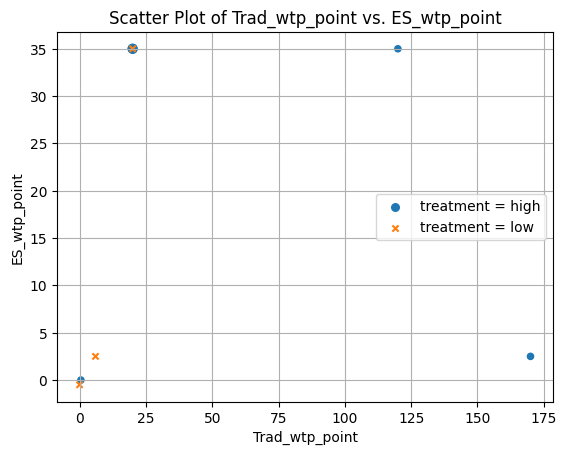

In [14]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json

def load_csv_files(subfolder_name):
    notebook_path = os.path.dirname(os.path.abspath('__file__'))
    data_folder_path = os.path.join(notebook_path, 'data', subfolder_name)

    all_dataframes = []
    
    # Get a list of all files in the subfolder
    files = os.listdir(data_folder_path)

    # Loop through each file and load it as a pandas DataFrame
    for file in files:
        if file.startswith('all_apps_wide') and file.endswith('.csv'):
            file_path = os.path.join(data_folder_path, file)
            df = pd.read_csv(file_path)
            all_dataframes.append(df)

    # Concatenate all DataFrames into one, stacking them on top of each other
    combined_df = pd.concat(all_dataframes, ignore_index=True)

    return combined_df

# Usage:
subfolder_name = '2023-08-dummy_data'
data = load_csv_files(subfolder_name)

# Remove duplicates based on all columns
data.drop_duplicates(inplace=True)

# Restrict to sessions:
def restrict_to_sessions(data, session_codes):
    return data[data['session.code'].isin(session_codes)]

session_codes = []
if session_codes:
    data = restrict_to_sessions(data, session_codes)

data.columns = data.columns.str.replace('participant.', '')

# List of pages to check against
pages_to_exclude = ['Welcome', 'Consent']

# Create new columns based on conditions
data['started_experiment'] = data['_current_page_name'].apply(lambda x: x not in pages_to_exclude and pd.notna(x))
data['finished_experiment'] = data['_current_page_name'].apply(lambda x: x in ['End','Finished'])

# Calculate completion rate
finished_experiment_count = data['finished_experiment'].sum()
started_experiment_count = data['started_experiment'].sum()
completion_rate = finished_experiment_count / started_experiment_count

print('Completion rate:', completion_rate)

# Filter the DataFrame to only include rows where 'finished_experiment' is True
data = data[data['finished_experiment']]

# Rename columns
data['mistakes_cq6'] = data['welfare.1.player.cq6_ambiguous_mistakes']+ data['welfare.1.player.cq6_treatments_mistakes']
data.rename(columns={'welfare.1.player.'+cq+'_mistakes': 'mistakes_'+cq for cq in ['cq1','cq2','cq3','cq4','cq5']}, inplace=True)
data['mistakes_total'] = data[['mistakes_cq1', 'mistakes_cq2', 'mistakes_cq3', 'mistakes_cq4', 'mistakes_cq5', 'mistakes_cq6']].sum(axis=1)

# Calculate share of entries where 'welfare.1.player.confirm' equals 1
total_entries = len(data)
count_equal_1 = data['welfare.1.player.confirm'].eq(1).sum()
share_equal_1 = count_equal_1 / total_entries

print('Participants who confirmed their answers the first time:', share_equal_1)

# Filter the DataFrame to only include rows where 'finished_experiment' is True
data = data[data['finished_experiment']]

# Functions to calculate values based on 'welfare.1.player.confirm'
def calculate_wtp(row, column_suffix):
    return row[f"welfare.{int(row['welfare.1.player.confirm'])}.player.{column_suffix}"]

for el in ['ES', 'Trad']:
    data[f'{el}_wtp'] = data.apply(lambda row: calculate_wtp(row, f'{el}_wtp'), axis=1)
    data[f'{el}_wtp2'] = data.apply(lambda row: calculate_wtp(row, f'{el}_wtp2'), axis=1)
    data[f'{el}_wtp3'] = data.apply(lambda row: calculate_wtp(row, f'{el}_wtp3'), axis=1)


data['original_first'] = data['choices_orders'].isin([1,3,6])

# Function to get WTP bounds
for el in ['ES', 'Trad']:
    def get_wtp_bound(row): 
        wtp3 = row[f'{el}_wtp3']
        if wtp3 is None or wtp3 is np.nan:
            return "WTP is None"
        cutoff = json.loads(wtp3)['cutoff']
        parts = cutoff.split(":")
        side = parts[0]
        row_choice = int(parts[1])

        if row['original_first']==False:
            side = {'left':'right','right':'left'}[side]

        if side == "right":
            row_choice = row_choice - 1
            side = "left"

        WTP_VALUES = [1, 2, 3, 5, 7, 10, 15, 25, 45, 70, 100, 140, 200, float('inf')]

        WTP_bound = (WTP_VALUES[row_choice + 1], WTP_VALUES[row_choice + 2])
        return WTP_bound
    
    data[f'{el}_wtp3_bounds'] = data.apply(get_wtp_bound,axis=1)

# Function to modify column1
def modify_column1(entry, col2_value, col3_value):
    if col2_value == 3:
        return (0, 0)
    elif col2_value == 2:
        if col3_value == 1:
            return (-1, 0)
        elif col3_value == 2:
            return (-float('inf'), 0)
    elif col2_value == 1:
        if col3_value == 2:
            return (0, 1)
        else: 
            return entry

# Function to calculate average
def calculate_average(tup):
    if np.inf in tup or -np.inf in tup:
        return tup[1] - 10 if tup[0] in [-np.inf,np.inf] else tup[0] + 10
    return (tup[0] + tup[1]) / 2

# Apply the function to modify 'Column1'
for el in ['ES', 'Trad']:
    data[f'{el}_wtp3_bounds'] = data.apply(lambda row: modify_column1(row[f'{el}_wtp3_bounds'], row[f'{el}_wtp'], row[f'{el}_wtp2']), axis=1)
    data[f'{el}_wtp_point'] = data[f'{el}_wtp3_bounds'].apply(calculate_average)

# Calculate the time difference and create a new column 'study_duration'
data['study_duration'] = data['end_time'] - data['start_time']

# Rename certain columns
data.rename(columns={'welfare.2.player.'+el: el for el in ['warhol','arkansas','experience'] + ['feedback'] + ['feedbackDifficulty', 'feedbackUnderstanding', 'feedbackSatisfied', 'feedbackPay']+ ['MPLWhy'] + ['warholWhy','arkansasWhy','experienceWhy']}, inplace=True)

# Create output folders if they don't exist
output_folder = os.path.join(os.getcwd(), 'output')
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

subfolder_path = os.path.join(output_folder, subfolder_name)
if not os.path.exists(subfolder_path):
    os.makedirs(subfolder_path)

# Functions to plot and save CDF, boxplot, and bar chart
def plot_and_save_cdf(data, column_names, filename):
    # Create a figure and axis
    fig, ax = plt.subplots()

    # Loop through the list of column names
    for column_name in column_names:
        # Calculate and plot the stepwise CDF
        sorted_data = np.sort(data[column_name])
        cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
        ax.step(sorted_data, cdf, where='post', label=column_name.capitalize())

    # Add labels and title
    ax.set_xlabel('Values')
    ax.set_ylabel('CDF')
    ax.set_title(f'Stepwise Cumulative Distribution Function of Columns')
    ax.legend()

    # Show the plot
    ax.grid(True)

    # Save the figure in the subfolder
    file_path = os.path.join(subfolder_path, f'stepwise_cdf_{filename}.png')
    plt.savefig(file_path)

    # Display the plot (optional)
    plt.show()

def plot_and_save_boxplot(data, column_names, filename):
    # Create a figure and axis
    fig, ax = plt.subplots()

    # Data for boxplot
    data_to_plot = [data[column_name] for column_name in column_names]

    # Create the boxplot
    ax.boxplot(data_to_plot, labels=column_names)

    # Add labels and title
    ax.set_ylabel('Values')
    ax.set_title(f'Boxplot of Columns')

    # Show the plot
    ax.grid(True)

    # Save the boxplot in the subfolder
    file_path = os.path.join(subfolder_path, f'boxplot_{filename}.png')
    plt.savefig(file_path)

    # Display the plot (optional)
    plt.show()

def plot_and_save_bar_chart(data, column_name, subfolder_name):
    # Create a figure and axis
    fig, ax = plt.subplots()

    # Data for bar chart
    value_counts = data[column_name].value_counts()

    # Create the bar chart with frequencies as heights and unique values as x-axis labels
    ax.bar(value_counts.index, value_counts)

    # Add labels and title
    ax.set_xlabel(column_name)
    ax.set_ylabel('Frequency')
    ax.set_title(f'Bar Chart of {column_name} Frequencies')

    # Show the plot
    ax.grid(True)

    # Save the bar chart in the subfolder
    file_path = os.path.join(subfolder_path, f'bar_chart_{column_name}_frequencies.png')
    plt.savefig(file_path)

    # Display the plot (optional)
    plt.show()

def plot_and_save_scatter(data, x_column, y_column, subfolder_name):
    # Create a figure and axis
    fig, ax = plt.subplots()

    # Get the counts of each unique pair of (x, y) coordinates
    counts = data.groupby([x_column, y_column]).size().reset_index(name='count')

    # Merge counts back with the original data to match (x, y) coordinates
    merged_data = data.merge(counts, on=[x_column, y_column])

    # Scatter plot with increased size for dots with multiple occurrences
    ax.scatter(merged_data[x_column], merged_data[y_column], s=merged_data['count'] * 10)  # You can adjust the multiplier (10 in this case) as needed

    # Add labels and title
    ax.set_xlabel(x_column)
    ax.set_ylabel(y_column)
    ax.set_title(f'Scatter Plot of {x_column} vs. {y_column}')

    # Show the plot
    ax.grid(True)

    # Create the subfolder if it doesn't exist
    subfolder_path = os.path.join('Output', subfolder_name)
    if not os.path.exists(subfolder_path):
        os.mkdir(subfolder_path)

    # Save the scatter plot in the subfolder
    file_path = os.path.join(subfolder_path, f'scatter_plot_{x_column}_vs_{y_column}.png')
    plt.savefig(file_path)

    # Display the plot (optional)
    plt.show()


def plot_and_save_scatter_with_condition(data, x_column, y_column, condition_column, condition_x, condition_y, subfolder_name):
    # Create a figure and axis
    fig, ax = plt.subplots()

    # Separate the data based on the condition_column
    data_x = data[data[condition_column] == condition_x]
    data_y = data[data[condition_column] == condition_y]

    # Get the counts of each unique pair of (x, y) coordinates for both conditions
    counts_x = data_x.groupby([x_column, y_column]).size().reset_index(name='count')
    counts_y = data_y.groupby([x_column, y_column]).size().reset_index(name='count')

    # Merge counts back with the original data to match (x, y) coordinates
    data_x = data_x.merge(counts_x, on=[x_column, y_column])
    data_y = data_y.merge(counts_y, on=[x_column, y_column])

    # Scatter plot for condition_x points with increased size for dots with multiple occurrences
    ax.scatter(data_x[x_column], data_x[y_column], label=f'{condition_column} = {condition_x}', marker='o', s=data_x['count'] * 20)

    # Scatter plot for condition_y points with increased size for dots with multiple occurrences
    ax.scatter(data_y[x_column], data_y[y_column], label=f'{condition_column} = {condition_y}', marker='x', s=data_y['count'] * 20)

    # Add labels and title
    ax.set_xlabel(x_column)
    ax.set_ylabel(y_column)
    ax.set_title(f'Scatter Plot of {x_column} vs. {y_column}')

    # Show the plot
    ax.grid(True)
    ax.legend()

    # Create the subfolder if it doesn't exist
    subfolder_path = os.path.join('Output', subfolder_name)
    if not os.path.exists(subfolder_path):
        os.mkdir(subfolder_path)

    # Save the scatter plot in the subfolder
    file_path = os.path.join(subfolder_path, f'scatter_plot_{x_column}_vs_{y_column}_with_condition.png')
    plt.savefig(file_path)

    # Display the plot (optional)
    plt.show()


# Call the functions to plot and save the desired graphs
plot_and_save_cdf(data, ['mistakes_total'], 'mistakes_total')
plot_and_save_boxplot(data, ['mistakes_total'], 'mistakes_total')
plot_and_save_cdf(data, ['Trad_wtp_point','ES_wtp_point'], 'wtp_point')
plot_and_save_boxplot(data, ['Trad_wtp_point','ES_wtp_point'], 'wtp_point')
plot_and_save_cdf(data,['study_duration'], 'study_duration')
plot_and_save_boxplot(data, ['study_duration'], 'study_duration')

for el in ['warhol','arkansas','experience']:
    plot_and_save_bar_chart(data, el, subfolder_name)

for el in ['feedbackDifficulty', 'feedbackUnderstanding', 'feedbackSatisfied', 'feedbackPay']:
    plot_and_save_bar_chart(data, el, subfolder_name)

for question in ['mistakes_cq1', 'mistakes_cq2', 'mistakes_cq3', 'mistakes_cq4','mistakes_cq5', 'mistakes_cq6']:
    # Call the function to plot and save the CDF for question
    plot_and_save_cdf(data, [question], subfolder_name)

    # Call the function to plot and save the boxplot for question
    plot_and_save_boxplot(data, [question], subfolder_name)

plot_and_save_scatter(data, 'Trad_wtp_point', 'ES_wtp_point', subfolder_name)
plot_and_save_scatter_with_condition(data, 'Trad_wtp_point', 'ES_wtp_point', 'treatment', 'high', 'low', subfolder_name)


# Select only the desired columns
selected_columns = ['label'] + ['warhol','arkansas','experience'] + ['warholWhy','arkansasWhy','experienceWhy']
selected_data = data[selected_columns]

# Save the selected data to a CSV file in the 'subfolder'
file_path = os.path.join(subfolder_path, 'open_ended.csv')
selected_data.to_csv(file_path, index=False)

# Select only the desired columns
selected_columns = ['label'] +  ['feedback'] + ['feedbackDifficulty', 'feedbackUnderstanding', 'feedbackSatisfied', 'feedbackPay']
selected_data = data[selected_columns]

# Save the selected data to a CSV file in the 'subfolder'
file_path = os.path.join(subfolder_path, 'feedback.csv')
selected_data.to_csv(file_path, index=False)

# Select only the desired columns
selected_columns = ['label'] + ['Trad_wtp3_bounds','ES_wtp3_bounds'] + ['treatment'] + ['mistakes_total']+ ['MPLWhy']
selected_data = data[selected_columns]

# Save the selected data to a CSV file in the 'subfolder'
file_path = os.path.join(subfolder_path, 'MPLWhy.csv')
selected_data.to_csv(file_path, index=False)
